# Testbed for TF2 Optimizers

Inspired by machinelearningmastery.com [blog posting](https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/)

Requires TF 2.x

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

## Setup

In [70]:
def loss_function0(x):
    return tf.reduce_sum((x * LOSS_FUNCTION_DIMENSION_SCALING)**2, axis=-1)

def loss_function1(x):
    return tf.reduce_sum(tf.math.cos(x * LOSS_FUNCTION_DIMENSION_SCALING)**2, axis=-1)

# select loss function to use
loss_function = loss_function1

In [71]:
IMAGE_DIR = './images/multi-modal3'
AXIS_LIMIT = 3
MAX_ITERATIONS = 1000
LEARNING_RATE = 0.1
INITIAL_POINT = [0.000, 0.000] #[0.001, 0.001] #[1.5, 0.01] #[1.7, -1.5]
LOSS_FUNCTION_DIMENSION_SCALING = [1, 2]
OPTIMIZERS = [
    tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE),    
    tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adadelta(learning_rate=LEARNING_RATE),
]

## Display Loss Surface For Reference

In [72]:
if IMAGE_DIR is not None:
    # setup directory for image save
    os.makedirs(IMAGE_DIR, exist_ok=True)

In [73]:
# generate plot points
x = tf.range(-AXIS_LIMIT, AXIS_LIMIT, 0.1, dtype=tf.float32)
y = tf.range(-AXIS_LIMIT, AXIS_LIMIT, 0.1, dtype=tf.float32)

t_list = tf.meshgrid(x, y, indexing='ij')
t = tf.stack(t_list, axis=-1)

# generate loss surface
loss_surface = loss_function(t)

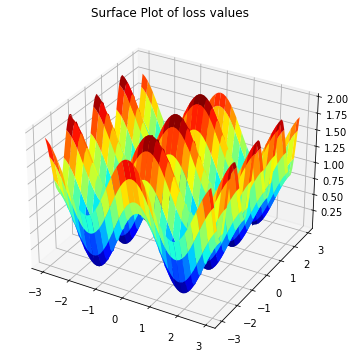

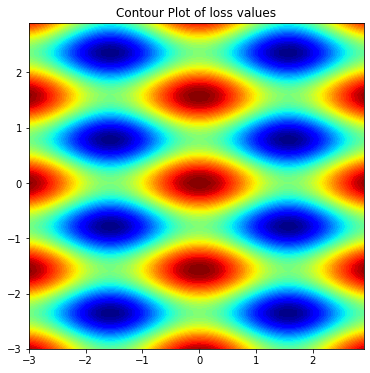

In [74]:

# display surface plot for loss_surface
figure = plt.figure(figsize=(6,6))
axis = figure.gca(projection='3d')
axis.plot_surface(t_list[0], t_list[1], 
                  loss_surface.numpy(), cmap='jet')
# show the plot
plt.title('Surface Plot of loss values')
if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'surface_plot.png'))
plt.show()

# display contour plot version
figure = plt.figure(figsize=(6,6))
plt.contourf(t_list[0], t_list[1], loss_surface, levels=50, cmap='jet')
# show the plot
plt.title('Contour Plot of loss values')
if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'contour_plot.png'))
plt.show()

## Test out different optimizers on the loss surface

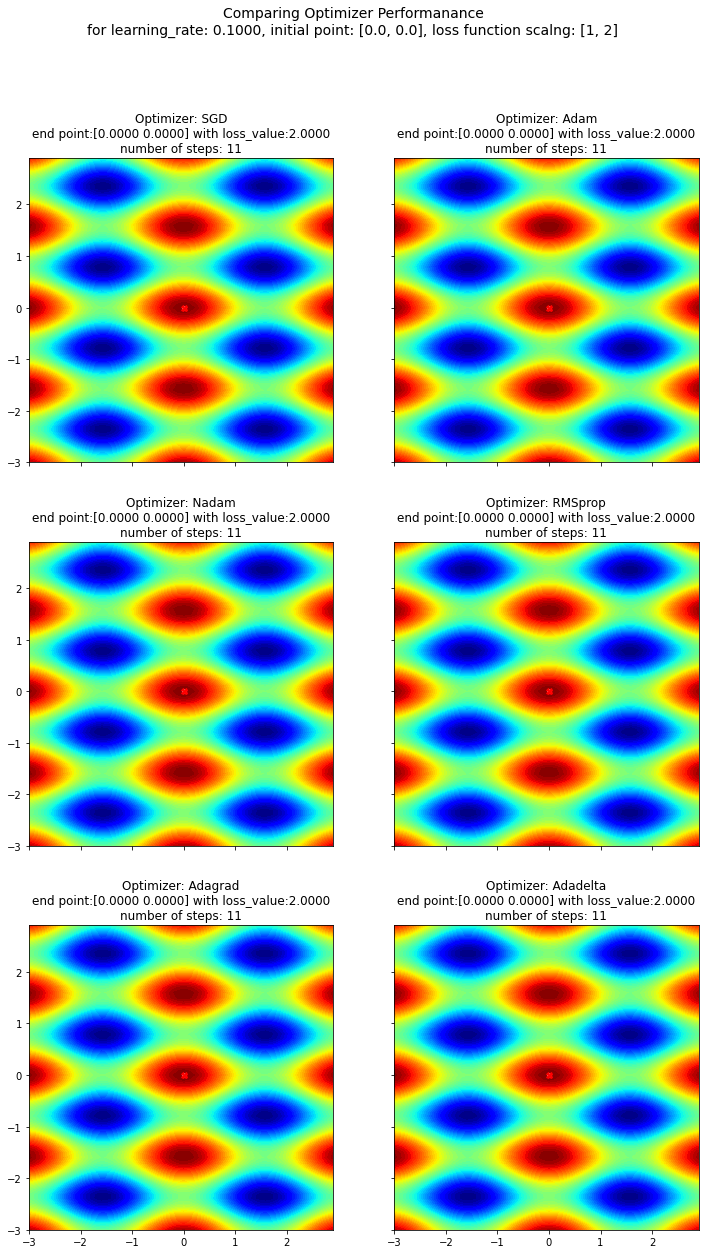

In [75]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12, 20))
for idx, optimizer in enumerate(OPTIMIZERS):
    row = idx // 2
    col = idx % 2
    ax[row, col].set_aspect(1)
    plt_ax = ax[row, col]

    # setup for looping through optimizers
    x = tf.Variable(INITIAL_POINT, dtype=tf.float32)  # set initial point
    trajectory_points = [x.numpy()]   # record initial starting point
    for _ in range(MAX_ITERATIONS):

        #calculate loss function 
        with tf.GradientTape() as tape:
            loss = loss_function(x)

        # calculate gradient
        var_list = [x]
        grad = tape.gradient(loss, var_list)

        # update solution using the calculated gradient
        optimizer.apply_gradients(zip(grad, var_list))
        trajectory_points.append(x.numpy())
        
        # test if we are approaching a limit point
        if len(trajectory_points) > 10:
            if np.abs(loss_function(trajectory_points[-1]) 
                      - loss_function(trajectory_points[-2])) < 1e-7:
                break

    # consolidate the trajectory the optimizer
    trajectory = np.stack(trajectory_points)

    # generate subplot for this optimizer
    # add contour plot
    plt_ax.contourf(t_list[0], t_list[1], loss_surface, levels=50, cmap='jet')
    
    # overlay optimizer trajectory path
    plt_ax.plot(trajectory[:,0], trajectory[:,1], '.-', color='w')
    
    # plot final point
    plt_ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'X', color='r')

    # add title for subplot
    plot_title = 'Optimizer: ' + optimizer._name 
    plot_title += '\nend point:' + np.array2string(trajectory[-1], 
                                           formatter={'float': lambda x: "%.4f" % x})
    plot_title += ' with loss_value:' + np.array2string(loss_function(trajectory[-1]).numpy(),
                                                   formatter={'float': lambda x: "%.4f" % x})
    plot_title += '\nnumber of steps: ' + '%d' % len(trajectory)
    plt_ax.set_title(plot_title)

# display all the subplots
sup_title = 'Comparing Optimizer Performanance'
sup_title += '\nfor learning_rate: %.4f' % LEARNING_RATE
sup_title += ', initial point: ' + str(INITIAL_POINT)
sup_title += ', loss function scalng: ' + str(LOSS_FUNCTION_DIMENSION_SCALING)
plt.suptitle(sup_title, fontsize=14)
if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'optimizer_plots.png'))
plt.show()